# Modelling

In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Add the '../imports' directory to the sys.path list
import sys
sys.path.append('../imports')
from helper_functions import split_datetime
from data_preprocessing import merge_data, remove_col
from actpred_plot import plot_actual_vs_pred


## Import Data

In [7]:
# Get the train data

DATA_DIR = "../data/"

# Read CSVs and parse relevant date columns
train = pd.read_csv(DATA_DIR + "train.csv")
client_train = pd.read_csv(DATA_DIR + "client.csv")
historical_weather_train = pd.read_csv(DATA_DIR + "historical_weather.csv")
forecast_weather_train = pd.read_csv(DATA_DIR + "forecast_weather.csv")
electricity_prices_train = pd.read_csv(DATA_DIR + "electricity_prices.csv")
gas_prices_train = pd.read_csv(DATA_DIR + "gas_prices.csv")
weather_station_to_county_mapping = pd.read_csv(DATA_DIR + 'weather_station_to_county_mapping.csv')

## Data Preprocessing

In [8]:
# We merge all DataFrames 
merged_train_df = merge_data(train, client_train, historical_weather_train,
        forecast_weather_train, electricity_prices_train, gas_prices_train, weather_station_to_county_mapping)

In [9]:
# Drop all non needed columns (ids and timestamps)
model_df = remove_col(merged_train_df)

In [10]:
model_df

,county,is_business,product_type,target,is_consumption,eic_count_client,installed_capacity_client,lowest_price_per_mwh_gas_prices,highest_price_per_mwh_gas_prices,euros_per_mwh_electricity_prices,...,surface_solar_radiation_downwards_forecast_weather,snowfall_forecast_weather,total_precipitation_forecast_weather,year,month,week,hour,day_of_year,day_of_month,day_of_week
0,0,0,1,0.713,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
1,0,0,1,96.590,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
2,0,0,2,0.000,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
3,0,0,2,17.314,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
4,0,0,3,2.904,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2021,9,35,0,244,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018347,15,1,0,197.233,1,15.0,620.0,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2
2018348,15,1,1,0.000,0,20.0,624.5,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2
2018349,15,1,1,28.404,1,20.0,624.5,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2
2018350,15,1,3,0.000,0,55.0,2188.2,29.0,34.0,-1.29,...,0.0,0.0,0.0,2023,5,22,23,151,31,2


## Train-Test-Split

In [34]:
X = model_df.drop('target', axis=1)
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

## Train the Model

We take the parameters from the model optimization (notebook 2.2)

In [35]:
model = XGBRegressor(enable_categorical=True, max_depth=9, learning_rate=0.3) 
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### conclusion on test/train split
- with the parameters set by grid search, the sizes of test and train data do not influence the quality of model results too much. 
- random state is not too important 
- using XGBoot's default parameters, the size makes a small difference. (Note: we did the grid search with all features, probably including ID columns...)

- Already here, we are overfitting!


## Evaluate Model

In [36]:
# Train Data

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# main optimisation metric
print('Mean absolute error test', mean_absolute_error(y_test, y_test_pred))
print('Mean absolute error train', mean_absolute_error(y_train, y_train_pred))

Mean absolute error test 51.91157352440664
Mean absolute error train 48.09196817727158


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

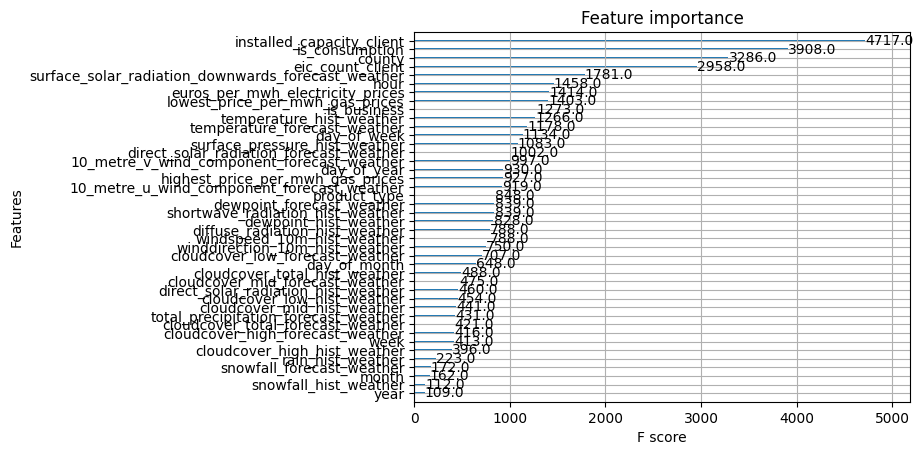

In [15]:
xgb.plot_importance(model)

- residuals are bigger at the summer time, we quess because production is happening at this time

- residuals on the test data have weekly pattern
- last two month predicted very poorly

- residuals are different depending on how we split our data 
- we see unexpalinable patterns in residuals
- residuals for consumption and production correlate with different features

- try residual analysis with traditional test_train_split

- tweak the model

> We tried to split the data into old and new data for training and testing. Because of bad scores we continue with a random train-test-split.

## Thinking: What features are important (or not)

- prices (should not influence consumption or production)

- we should check correlation heat maps to identify parameters that are highly correlated (although XGBoost seems to be able to handle correlated features well)
- this way we might be able to eliminate some weather related features that cover the same 'topic'


'county',                                   
 'is_business',
 'product_type',
 'target',
 'is_consumption',
 'eic_count_client',
 'installed_capacity_client',
 'lowest_price_per_mwh_gas_prices',             -> maybe drop the prices, we think prices correlate with season more than consumer behavior 
 'highest_price_per_mwh_gas_prices',
 'euros_per_mwh_electricity_prices',
 'temperature_hist_weather',
 'dewpoint_hist_weather',
 'rain_hist_weather',                           -> rain may be not too important (can only happen with cloud cover anyway, and cloud cover may 
 'snowfall_hist_weather',                               be a better feature)
 'surface_pressure_hist_weather',
 'cloudcover_total_hist_weather',            -> cloud cover influences solar radiation... is maybe redundant
 'cloudcover_low_hist_weather',                   drop other cloud covers and only keep total
 'cloudcover_mid_hist_weather',
 'cloudcover_high_hist_weather',
 'windspeed_10m_hist_weather',
 'winddirection_10m_hist_weather',
 'shortwave_radiation_hist_weather',
 'direct_solar_radiation_hist_weather',
 'diffuse_radiation_hist_weather',
 'temperature_forecast_weather',
 'dewpoint_forecast_weather',
 'cloudcover_high_forecast_weather',
 'cloudcover_low_forecast_weather',
 'cloudcover_mid_forecast_weather',
 'cloudcover_total_forecast_weather',
 '10_metre_u_wind_component_forecast_weather',
 '10_metre_v_wind_component_forecast_weather',
 'direct_solar_radiation_forecast_weather',
 'surface_solar_radiation_downwards_forecast_weather',
 'snowfall_forecast_weather',
 'total_precipitation_forecast_weather',
 'year',
 'month',
 'week',
 'hour',
 'day_of_year',
 'day_of_month',
 'day_of_week']                             -> seemed important in EDA and in feature importance plot    

## feature selection and engineering

selected features, as found by the sequential feature selector in 02.2_Model_Optimization.ipynb:

['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client', 'installed_capacity_client',
       'rain_hist_weather', 'snowfall_hist_weather',
       'cloudcover_total_hist_weather', 'cloudcover_mid_hist_weather',
       'cloudcover_high_hist_weather', 'diffuse_radiation_hist_weather',
       'temperature_forecast_weather', 'dewpoint_forecast_weather',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week']

In [58]:
# hard-coded list of selected features, found by sequential feature selector

sel_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client', 'installed_capacity_client',
       'rain_hist_weather', 'snowfall_hist_weather',
       'cloudcover_total_hist_weather', 'cloudcover_mid_hist_weather',
       'cloudcover_high_hist_weather', 'diffuse_radiation_hist_weather',
       'temperature_forecast_weather', 'dewpoint_forecast_weather',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week']

In [65]:
# Run model with selected features


df = model_df.copy()
## do stuff to model_df

# only keep columns selected by SFS
cols = sel_features
df = df[cols]

# train-test split
X = df
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# training
model = XGBRegressor(enable_categorical=True) 
model.fit(X_train, y_train)

# evaluation
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# main optimisation metric
print('Mean absolute error test', mean_absolute_error(y_test, y_test_pred))
print('Mean absolute error train', mean_absolute_error(y_train, y_train_pred))

Mean absolute error test 49.646839153001004
Mean absolute error train 48.56717060826106


> these are the best results so far (not in terms of absolute values for train, but in terms of preventing overfitting)

In [75]:
# get MAE for prod and cons separately

X_test_prod = X_test[X_test["is_consumption"] == 0]
y_test_prod = y_test[X_test["is_consumption"] == 0]
y_test_pred_prod = y_test_pred[X_test["is_consumption"] == 0]

X_test_con = X_test[X_test["is_consumption"] == 1]
y_test_con = y_test[X_test["is_consumption"] == 1]
y_test_pred_con = y_test_pred[X_test["is_consumption"] == 1]

print('Mean absolute error test production', mean_absolute_error(y_test_prod, y_test_pred_prod))
print('Mean absolute error test consumption', mean_absolute_error(y_test_con, y_test_pred_con))

print('Mean absolute percentage error test production', mean_absolute_percentage_error(y_test_pred_prod, y_test_prod))
print('Mean absolute percentage error test consumption', mean_absolute_percentage_error(y_test_pred_con,y_test_con))


## predicting consumption is more accurate than predicting production (we have seen in EDA that there is a lot of fluctuation in production)

Mean absolute error test production 33.653912339635184
Mean absolute error test consumption 65.65065446170694
Mean absolute percentage error test production 2.3008028935720817
Mean absolute percentage error test consumption 1.4278450030226715


> predicting consumption is more accurate than predicting production (we have seen in EDA that there is a lot of fluctuation in production)

In [79]:
# skip for now, we are missing the month column now and this makes reconstruction of date hard...


# # Use the index of X_test to merge the target values back from the original dataset
X_test_with_target = X_test
X_test_with_target['target'] = y_test
X_test_with_target['predicted'] = y_test_pred
# # Re-introducing a datetime column to represent date
# X_test_with_target['datetime'] = pd.to_datetime(
#     {
#         'year': X_test_with_target['year'],
#         'month': X_test_with_target['month'],
#         'day': X_test_with_target['day_of_month']
#     }
# )

# plot_actual_vs_pred(X_test_with_target)

In [83]:
X_test_with_target.query('is_consumption==0 & target == 0').describe().T

,count,mean,std,min,25%,50%,75%,max
is_business,105510.0,0.625562,0.48398,0.0,0.0,1.0,1.0,1.0
is_consumption,105510.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
eic_count_client,104969.0,31.526946,41.978135,5.0,10.0,17.0,39.0,741.0
installed_capacity_client,104969.0,777.147086,963.560037,6.0,253.0,470.0,1046.8,17879.38
rain_hist_weather,103839.0,0.035941,0.151778,0.0,0.0,0.0,0.0,4.1
snowfall_hist_weather,103839.0,0.024873,0.089553,0.0,0.0,0.0,0.0,2.1
cloudcover_total_hist_weather,103839.0,68.537503,35.679158,0.0,37.0,86.166667,100.0,100.0
cloudcover_mid_hist_weather,103839.0,37.739903,39.12048,0.0,0.0,21.666667,80.0,100.0
cloudcover_high_hist_weather,103839.0,37.203108,40.97248,0.0,0.0,14.75,85.0,100.0
diffuse_radiation_hist_weather,103839.0,1.813816,9.834652,0.0,0.0,0.0,0.0,235.75


## Feature engineering

sel_features = ['county', 'is_business', 'product_type', 'is_consumption',
       'eic_count_client', 'installed_capacity_client',
       'rain_hist_weather', 'snowfall_hist_weather',
       'cloudcover_total_hist_weather', 'cloudcover_mid_hist_weather',
       'cloudcover_high_hist_weather', 'diffuse_radiation_hist_weather',
       'temperature_forecast_weather', 'dewpoint_forecast_weather',
       'surface_solar_radiation_downwards_forecast_weather',
       'total_precipitation_forecast_weather', 'year', 'week', 'hour',
       'day_of_year', 'day_of_week']

IDEAS 
- holidays (christmas, easter, ...)
- workday vs weekend
- increasing in the capacity (??)
- weather aggregation for previous/future period
- prices aggregation for previous period (discard)

- daylight (or not), possibly boolean? ---> if false, set production 0
       - based on time, sunlight, cloudcover
       - essentially solar radiation should be enough, it already indicates if the sun is shining or not. 
- capacity per client ('eic_count' / )
- square the capacity, to give it a bigger weight (to exaggerate the trend in increasing capacity)
- some scale that represents the growth in capacity (could be different in the segments?)
- how much of the capacity is actually used at any time (capacity / production)

TO DO
- replace negative targets with 0 (neither production nor consumption can be negative)


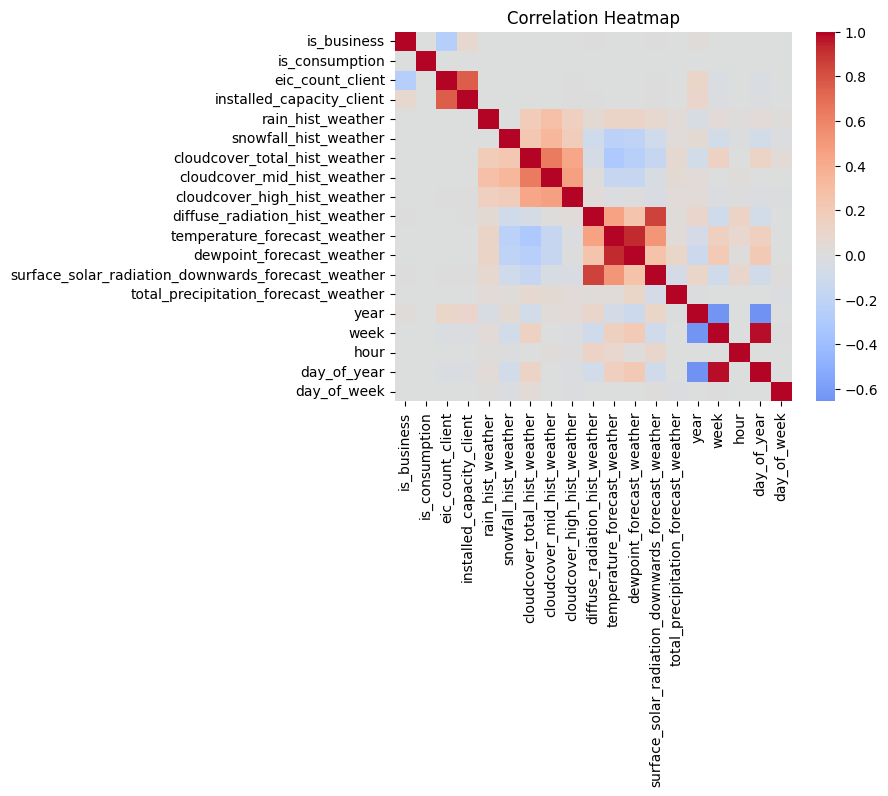

In [66]:
numeric_columns = model_df[sel_features].select_dtypes(include=[np.number])
correlation_matrix = numeric_columns.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [67]:
def error_analysis(y_test, y_test_pred):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_test_pred
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_test_pred, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, y_test_pred.max()+10], [-400, y_test_pred.max()+10], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    # ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    # ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    ax[0].set_xlim((y_test_pred.min()-10), (y_test_pred.max()+10))
    ax[0].set_ylim((y_test_pred.min()-10), (y_test_pred.max()+10))


    ax[1].scatter(y_test_pred, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, y_test_pred.max()+10], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_test_pred.min()-10), (y_test_pred.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

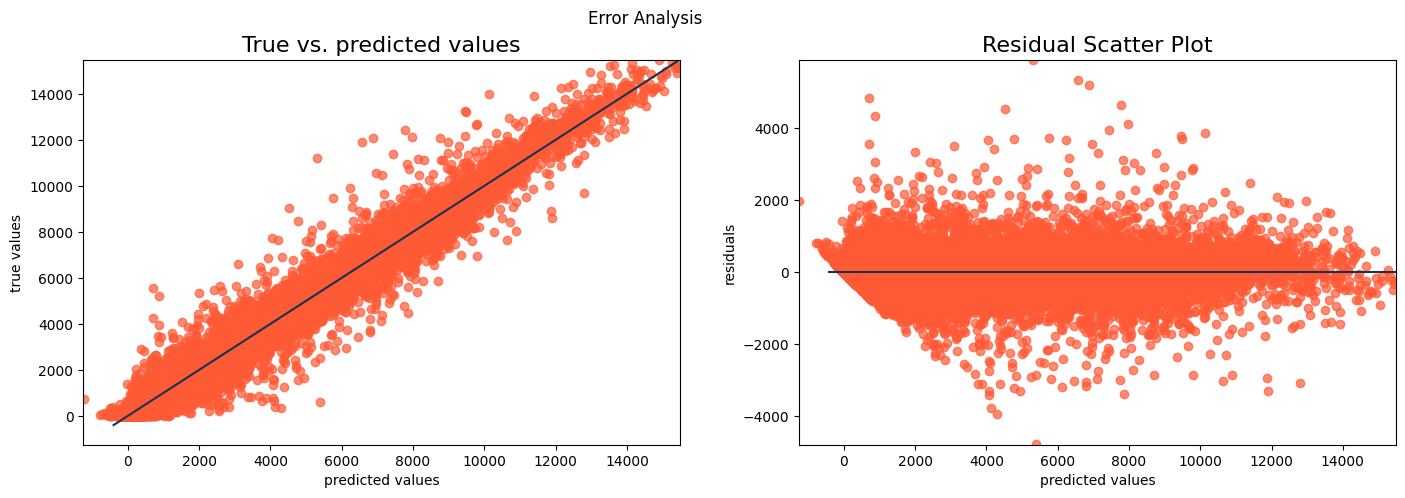

In [68]:
error_analysis(y_test, y_test_pred)

looking good!

# old stuff

In [9]:
# split of old data to train and newer one to test

# Xy_train = model_df[model_df.data_block_id < 450]
# X_train = Xy_train.drop('target', axis=1)
# y_train = Xy_train.target

# Xy_test = model_df[model_df.data_block_id >= 450]
# X_test = Xy_test.drop('target', axis=1)
# y_test = Xy_test.target

# bst = XGBRegressor(enable_categorical=True)
# bst.fit(X_train, y_train)
# y_pred = bst.predict(X_test)

# # main optimisation metric
# print('Mean absolute error test', mean_absolute_error(y_test, y_pred))
# print('Mean absolute error train', mean_absolute_error(y_train, bst.predict(X_train)))

In [10]:
# divide by dates and use newer ones for validation

In [11]:
# target_column = 'residual'

# # Exclude non-numeric columns
# numeric_columns = Xy_test.select_dtypes(include=['number']).columns
# numeric_df = Xy_test[numeric_columns]
# numeric_df_cons = numeric_df[numeric_df['is_consumption'] == 1]

# # Calculate the correlation matrix
# correlation_matrix = numeric_df_cons.corr()

# # Select correlations based on the threshold
# threshold = 0.15
# significant_correlations = correlation_matrix[(correlation_matrix[target_column] > threshold) | (correlation_matrix[target_column] < -threshold)][target_column]

# # Plot a heatmap of the significant correlations with the target
# plt.figure(figsize=(12, 8))
# sns.heatmap(significant_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
# plt.title(f'Significant Correlations with {target_column}, CONSUM ONLY (Threshold: {threshold})')
# plt.show()

In [12]:
# target_column = 'residual'

# # Exclude non-numeric columns
# numeric_columns = Xy_test.select_dtypes(include=['number']).columns
# numeric_df = Xy_test[numeric_columns]
# numeric_df_cons = numeric_df[numeric_df['is_consumption'] == 0]

# # Calculate the correlation matrix
# correlation_matrix = numeric_df_cons.corr()

# # Select correlations based on the threshold
# threshold = 0.15
# significant_correlations = correlation_matrix[(correlation_matrix[target_column] > threshold) | (correlation_matrix[target_column] < -threshold)][target_column]

# # Plot a heatmap of the significant correlations with the target
# plt.figure(figsize=(12, 8))
# sns.heatmap(significant_correlations.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
# plt.title(f'Significant Correlations with {target_column}, PRODUCTION ONLY (Threshold: {threshold})')
# plt.show()